In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 

In [2]:
from torchvision.io import read_image

def read_image_to_tensor(path):
    return read_image(path)/255

In [3]:
def show_tensor_image(image, cmap=None):
    permuted = image.permute(1, 2, 0)
    plt.imshow(permuted, cmap)

1.

torch.Size([3, 1080, 1080])


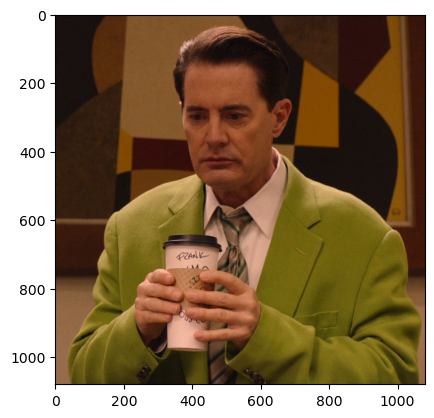

In [4]:
IMG = read_image_to_tensor('dj.jpg')
show_tensor_image(IMG)
print(IMG.shape)

2.

In [5]:
def conv2d(image, filter_2d, kernel_size, in_channels=1, out_channels=1, stride=1, padding=0):
    kernel = filter_2d.view(out_channels, in_channels, kernel_size[0], kernel_size[1])

    conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
    conv.weight.data = kernel

    return conv(image)

In [6]:
filter_2d = torch.tensor([[1.0, 1.0, 1.0]])

torch.Size([1, 1080, 1080])


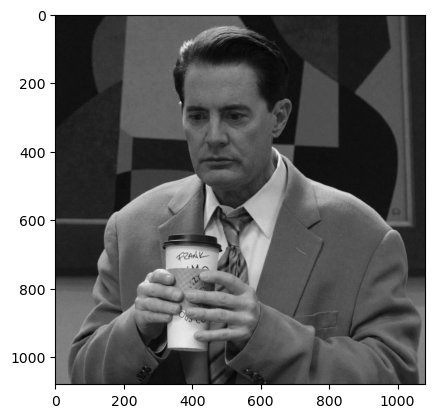

In [7]:
IMG_gray = conv2d(IMG, filter_2d=filter_2d, kernel_size=(1,1), in_channels=3)
print(IMG_gray.shape)
show_tensor_image(IMG_gray.detach(), cmap="gray")

3.

In [8]:
max_pool = nn.MaxPool2d(4, 4)

torch.Size([1, 270, 270])


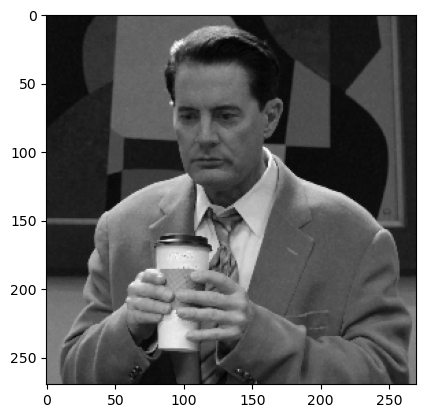

In [9]:
IMG_pool = max_pool(IMG_gray)
print(IMG_pool.shape)
show_tensor_image(IMG_pool.detach(), cmap="gray")

4.

In [10]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x = torch.arange(-size, size + 1, dtype=torch.float32)
    y = torch.arange(-size, size + 1, dtype=torch.float32)
    x_grid, y_grid = torch.meshgrid(x, y, indexing='ij')
    
    normal = 1 / (2.0 * torch.pi * sigma**2)
    g = torch.exp(-((x_grid**2 + y_grid**2) / (2.0 * sigma**2))) * normal
    return g

In [11]:
n = 3

In [12]:
gaussian_filter = gaussian_kernel(n, 1)

torch.Size([1, 270, 270])


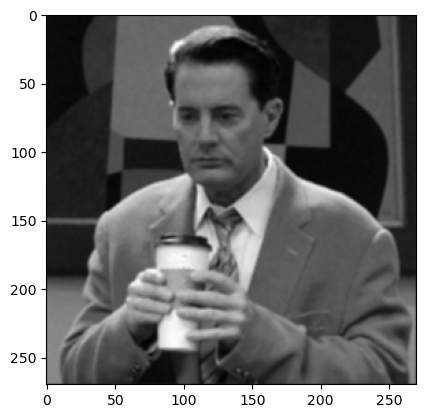

In [13]:
IMG_gauss = conv2d(IMG_pool, filter_2d=gaussian_filter, kernel_size=(n, n), padding=n//2)
print(IMG_gauss.shape)
show_tensor_image(IMG_gauss.detach(), cmap="gray")

5. 

In [14]:
sobel_x = torch.tensor([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]
]).float()

sobel_y = torch.tensor([
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1]
]).float()

filter_2d = torch.stack([sobel_x, sobel_y]).unsqueeze(1)

In [15]:
IMG_sobel = conv2d(image=IMG_gauss, filter_2d=filter_2d, kernel_size=(3, 3), out_channels=2, padding=1)

In [16]:
IMG_sobel_x = IMG_sobel[0].unsqueeze(0)
IMG_sobel_y = IMG_sobel[1].unsqueeze(0)

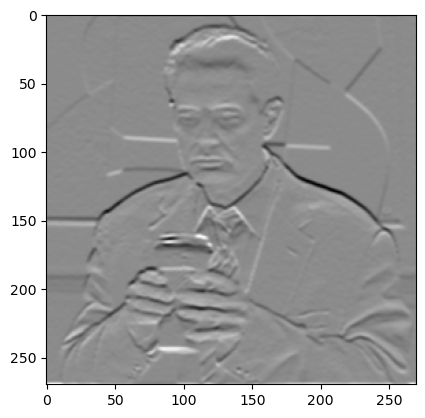

In [17]:
show_tensor_image(IMG_sobel_x.detach(), cmap="gray")

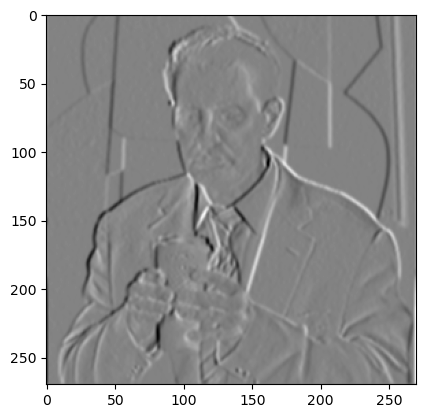

In [18]:
show_tensor_image(IMG_sobel_y.detach(), cmap="gray")

In [19]:
IMG_norm = (IMG_sobel_x**2 + IMG_sobel_y**2)**(1/2)

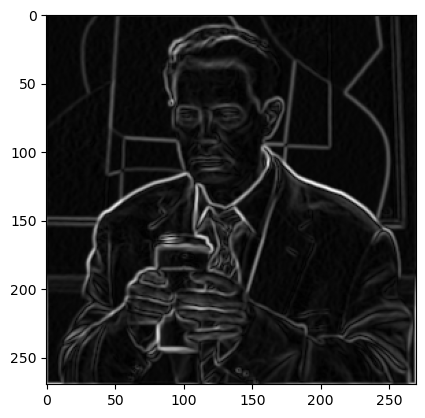

In [20]:
show_tensor_image(IMG_norm.detach(), cmap="gray")

In [21]:
IMG_grad = torch.arctan(IMG_sobel_y/IMG_sobel_x)

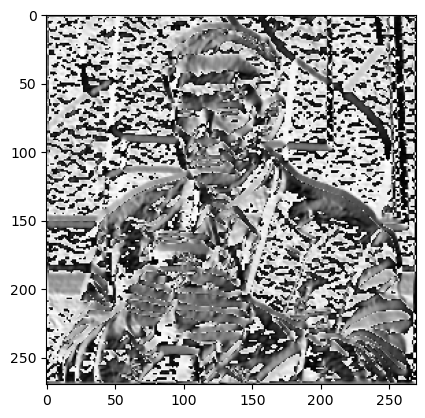

In [22]:
show_tensor_image(IMG_grad.detach(), cmap="gray")

In [23]:
def non_max_suppression(img, D):
    M, N = img.shape

    Z = torch.zeros((M, N), dtype=torch.int32)
    
    angle = D * 180. / torch.pi
    angle[angle < 0] += 180

    for i in range(1, M-1):
        for j in range(1, N-1):
            q = 255
            r = 255
            
            # angle 0
            if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                q = img[i, j + 1]
                r = img[i, j - 1]
            # angle 45
            elif (22.5 <= angle[i, j] < 67.5):
                q = img[i + 1, j - 1]
                r = img[i - 1, j + 1]
            # angle 90
            elif (67.5 <= angle[i, j] < 112.5):
                q = img[i + 1, j]
                r = img[i - 1, j]
            # angle 135
            elif (112.5 <= angle[i, j] < 157.5):
                q = img[i - 1, j - 1]
                r = img[i + 1, j + 1]

            if (img[i, j] >= q) and (img[i, j] >= r):
                Z[i, j] = img[i, j]
            else:
                Z[i, j] = 0

    return Z


In [24]:
IMG_non_max = non_max_suppression(IMG_norm[0], IMG_grad[0])

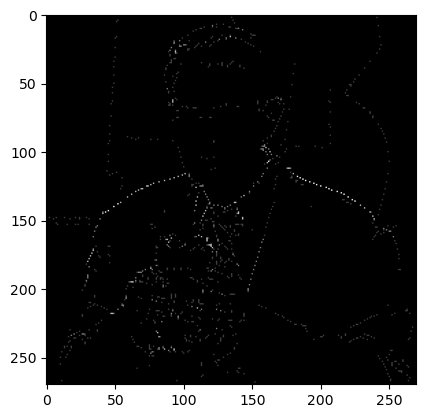

In [25]:
plt.imshow(IMG_non_max, cmap='gray')

In [26]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):

    highThreshold = img.max() * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio

    res = torch.zeros_like(img, dtype=torch.int32)
    weak = torch.tensor(25, dtype=torch.int32)
    strong = torch.tensor(255, dtype=torch.int32)

    strong_mask = img >= highThreshold
    weak_mask = (img <= highThreshold) & (img >= lowThreshold)
    
    res[strong_mask] = strong
    res[weak_mask] = weak

    return res, weak, strong

In [27]:
IMG_non_max_rgb = torch.stack([IMG_non_max, IMG_non_max, IMG_non_max], dim=0)
IMG_thr = threshold(IMG_non_max_rgb)[0]

torch.Size([3, 270, 270])


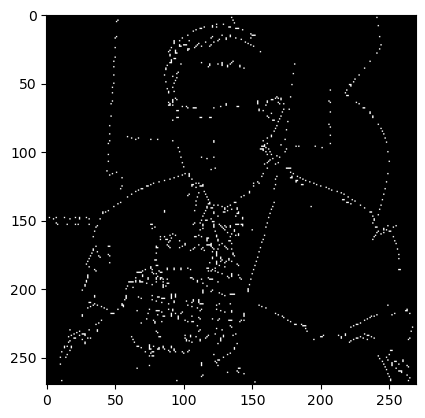

In [28]:
print(IMG_thr.shape)
show_tensor_image(IMG_thr)

In [29]:
def dilate(t, k):
    x = t.squeeze()
    x = x.unsqueeze(-1).expand([*x.shape,k])
    x = x.unsqueeze(-1).expand([*x.shape,k])
    x = torch.cat([*x], dim=1)
    x = torch.cat([*x], dim=1)
    x = x.unsqueeze(0)
    return x

B = dilate(IMG_thr[0], 4)

torch.Size([1, 1080, 1080])


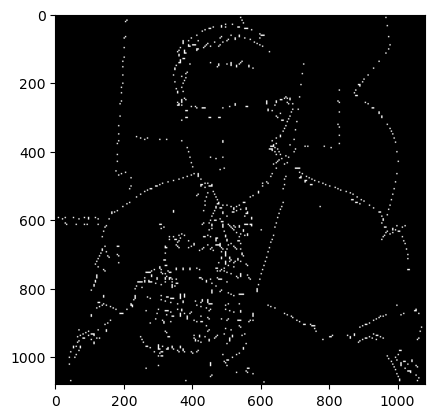

In [30]:
print(B.shape)
show_tensor_image(B, cmap='gray')

In [31]:
def draw_shapes(image, lines):
    lines_rgb = torch.stack((lines[0]*0, lines[0], lines[0]*0), dim=0)
    print(lines_rgb.shape, image.shape)
    result = image + lines_rgb

    return result

In [32]:
output = draw_shapes(IMG, B)

torch.Size([3, 1080, 1080]) torch.Size([3, 1080, 1080])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 1080, 1080])


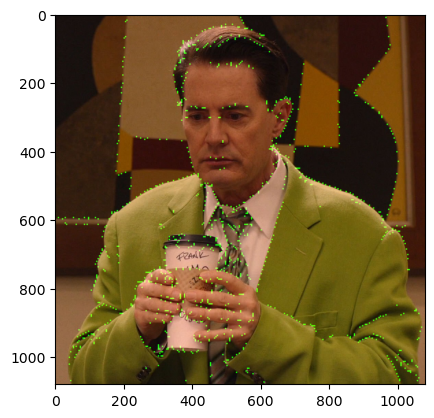

In [33]:
print(output.shape)
show_tensor_image(output)